In [36]:
import numpy as np
import pandas as pd
import sunpy
import sunpy.map
from scipy import signal
import copy
from numpy.linalg import solve
from glob import glob
from datetime import datetime
from scipy.linalg import lstsq
import matplotlib.pyplot as plt

In [37]:
# Defining the paths where the fits are
path_Br = glob('E:/Research/Data/HMI/SHARP_recon_test/*00_TAI.Br.fits')
path_Bp = glob('E:/Research/Data/HMI/SHARP_recon_test/*00_TAI.Bp.fits')
path_Bt = glob('E:/Research/Data/HMI/SHARP_recon_test/*00_TAI.Bt.fits')

# Building the cubes using Sunpy
cube_Br = sunpy.map.Map(path_Br, sequence=True)
cube_Bp = sunpy.map.Map(path_Bp, sequence=True)
cube_Bt = sunpy.map.Map(path_Bt, sequence=True)

# Creating empty lists to receive the datacubes
data_cube_Br = []
data_cube_Bp = []
data_cube_Bt = []
meta_cube_Bp = []

for i in range(0, len(cube_Br)):
    data_cube_Br.append(cube_Br[i].data)
    data_cube_Bp.append(cube_Bp[i].data)
    data_cube_Bt.append(cube_Bt[i].data)
    meta_cube_Bp.append(cube_Bp[i].meta)

# Getting meta infomation    
meta = meta_cube_Bp[0]

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]


First of all it is necessary to make the datacubes using the magnetic field vector components.
Here we use data from SDO-HMI SHARPs (hmi.sharp_cea_720s) in spherical coordinates. Which means that $$B_{r} = B_{z}$$  $$B_{\phi} = B_{x}$$ $$B_{\theta} = - B_{y}$$

In [38]:
# Reshaping sothat the frames stack in the third axis
data_cube_Br = np.transpose(np.array(data_cube_Br), (2, 1, 0)) # [G]
data_cube_Bp = np.transpose(np.array(data_cube_Bp), (2, 1, 0)) # [G]
data_cube_Bt = np.transpose(np.array(data_cube_Bt), (2, 1, 0)) # [G]

# Converting magnetic field from spherical coordinate to local Cartesian coordinate
data_cube_Bx = data_cube_Bp
data_cube_By = np.multiply(-1, data_cube_Bt)
data_cube_Bz = data_cube_Br

In [39]:
# Defining grid for reconstruction, [km] as length unit, [s] as time uint
Rs = 6.9634e5 # solar radia, [km]
Ve = 0.3 # emerge velocity, [km/s]

# X and Y grid
dtheta, dphi = 0.03, 0.03 # [deg.]
dx = np.deg2rad(dtheta) * Rs
dy = np.deg2rad(dphi) * Rs
x = range(0, meta['naxis1']) * dx
y = range(0, meta['naxis2']) * dy

# Z grid
dz = []
z = [0]
for i in range(0, len(cube_Br)-1):
    # Finding neighbouring frame
    t1 = datetime.strptime(meta_cube_Bp[i]['date-obs'], "%Y-%m-%dT%H:%M:%S.%f")
    t2 = datetime.strptime(meta_cube_Bp[i+1]['date-obs'], "%Y-%m-%dT%H:%M:%S.%f")
    # Calculating the time interval
    dt = (t2-t1).total_seconds() # [s]
    dz_sub = Ve * dt # [km]
    dz.append(dz_sub)
    z.append(z[-1]-dz_sub)
dz = np.array(dz)

x, y, z = np.array(x), np.array(y), np.array(z)


In [40]:
# Interpolating to std grid with uniform spacing
from scipy.interpolate import interp1d

def interpolate_along_z(data_cube_B, x, y, z, dz_std):
    z_std = np.arange(z[0], z[-1] - dz_std, -dz_std)
    data_cube_B_interp = np.zeros((len(x), len(y), len(z_std)))

    for i in range(len(x)):
        for j in range(len(y)):
            slice_z = data_cube_B[i, j, :]
            f_interp = interp1d(z, slice_z, kind='linear', bounds_error=False, fill_value='extrapolate')
            data_cube_B_interp[i, j, :] = f_interp(z_std)
    
    return data_cube_B_interp, z_std

# Sparsing along z axis
sparse_factor = 10
dz_std = int(dz[0]) * sparse_factor
data_cube_Bx_interp, z_std = interpolate_along_z(data_cube_Bx, x, y, z, dz_std)
data_cube_By_interp, _ = interpolate_along_z(data_cube_By, x, y, z, dz_std)
data_cube_Bz_interp, _ = interpolate_along_z(data_cube_Bz, x, y, z, dz_std)

# Sparsing along x and y axes
dx_std, dy_std = dx*sparse_factor, dy*sparse_factor
x, y = x[::sparse_factor], y[::sparse_factor]
xx, yy, zz = np.meshgrid(x, y, z_std, indexing='ij')

data_cube_Bx = data_cube_Bx_interp[::sparse_factor, ::sparse_factor, :]
data_cube_By = data_cube_By_interp[::sparse_factor, ::sparse_factor, :]
data_cube_Bz = data_cube_Bz_interp[::sparse_factor, ::sparse_factor, :]

In [41]:
# Checking grid spacing and data shape
print('dx=', dx_std, 'km')
print('dy=', dy_std, 'km')
print('dz=', dz_std, 'km')

print('Data shape: ', data_cube_Bz.shape)
print('Grid shape: ', xx.shape)

dx= 3646.027714001194 km
dy= 3646.027714001194 km
dz= 2160 km
Data shape:  (121, 52, 46)
Grid shape:  (121, 52, 46)


In [42]:
# Calculating the residual divergence of 3D field
from field_analyse_utils import calc_field_divergence

div_B = calc_field_divergence(data_cube_Bx, data_cube_By, data_cube_Bz, xx, yy, zz) # [G/km]

In [43]:
# Saving interpolated field data
xx_flat, yy_flat, zz_flat = xx.flatten(), yy.flatten(), zz.flatten()
data_cube_Bx_flat, data_cube_By_flat, data_cube_Bz_flat = data_cube_Bx.flatten(), data_cube_By.flatten(), data_cube_Bz.flatten()
div_B_flat = div_B.flatten()

# Organizing dataframes 
data_origin_save = pd.DataFrame({
    'xx': xx_flat,
    'yy': yy_flat,
    'zz': zz_flat,
    'data_cube_Bx': data_cube_Bx_flat,
    'data_cube_By': data_cube_By_flat,
    'data_cube_Bz': data_cube_Bz_flat,
    'div_B': div_B_flat
})

# Saving data to csv files
save_dir = 'E:/Research/Work/202405_solar_storm/reconstruction/sparse_factor=' + str(sparse_factor) + '/'
origin_save_name = 'origin_field_data_' + str(Ve) + '.csv'
data_origin_save.to_csv(save_dir + origin_save_name, index=False)

In [45]:
# Importing Poisson solutions calculated by poisson-master/solve_poisson.py
poiss_dir = 'E:/Research/Work/202405_solar_storm/reconstruction/sparse_factor=' + str(sparse_factor) + '/'
poiss_name = 'Poisson_solution_' + str(Ve) + '.csv'
poiss_data = pd.read_csv(poiss_dir+poiss_name)

# cut grid of Poisson solutions
nx, ny, nz = data_cube_Bz.shape
if sparse_factor == 3:
    nx_cut, nz_cut = 171, 149
elif sparse_factor == 5:
    nx_cut, nz_cut = 129, 89
elif sparse_factor == 10:
    nx_cut, nz_cut = 52, 46
elif sparse_factor == 25:
    nx_cut, nz_cut = 21, 19
nx_beg = (nx-nx_cut) // 2
nx_end = nx_beg + nx_cut
nz_beg = (nz-nz_cut) // 2
nz_end = nz_beg + nz_cut

# Extracting dataframes
xx_cut_flat = poiss_data['xx_cut'].values
yy_cut_flat = poiss_data['yy_cut'].values
zz_cut_flat = poiss_data['zz_cut'].values
psi_flat = poiss_data['psi'].values # [G km]

# Reshaping Poisson solutions data
xx_cut = xx_cut_flat.reshape((nx_cut, ny, nz_cut))
yy_cut = yy_cut_flat.reshape((nx_cut, ny, nz_cut))
zz_cut = zz_cut_flat.reshape((nx_cut, ny, nz_cut))
psi = psi_flat.reshape((nx_cut, ny, nz_cut))

In [46]:
# Calculating residual field and substracting it
from field_analyse_utils import calc_field_gradient

Bx_res, By_res, Bz_res = calc_field_gradient(psi, xx_cut, yy_cut, zz_cut) # [G]

# Cutting off original field to match the Poisson solutions
Bx_cut = data_cube_Bx[nx_beg:nx_end, :, nz_beg:nz_end]
By_cut = data_cube_By[nx_beg:nx_end, :, nz_beg:nz_end]
Bz_cut = data_cube_Bz[nx_beg:nx_end, :, nz_beg:nz_end]

# Substracting residual field from original field
Bx = Bx_cut - Bx_res
By = By_cut - By_res
Bz = Bz_cut - Bz_res

In [47]:
div_B_res = calc_field_divergence(Bx, By, Bz, xx_cut, yy_cut, zz_cut)
print('max residual divergence: ', np.nanmax(np.abs(div_B_res)))

max residual divergence:  2.338403776169784e-12


In [48]:
# Saving resulting field data
Bx_flat, By_flat, Bz_flat = Bx.flatten(), By.flatten(), Bz.flatten()

# Organizing dataframes 
data_result_save = pd.DataFrame({
    'xx': xx_cut_flat,
    'yy': yy_cut_flat,
    'zz': zz_cut_flat,
    'Bx': Bx_flat,
    'By': By_flat,
    'Bz': Bz_flat
})

# Saving data to csv files
save_dir = 'E:/Research/Work/202405_solar_storm/reconstruction/sparse_factor=' + str(sparse_factor) + '/'
result_save_name = 'result_field_data_' + str(Ve) + '.csv'
data_result_save.to_csv(save_dir + result_save_name, index=False)

In [49]:
B_mod = np.sqrt(Bx**2 + By**2 + Bz**2)
B_mod_mean = np.nanmean(B_mod)

div_B_norm = div_B / (B_mod_mean/dz_std)
div_B_res_norm = div_B_res / (B_mod_mean/dz_std)

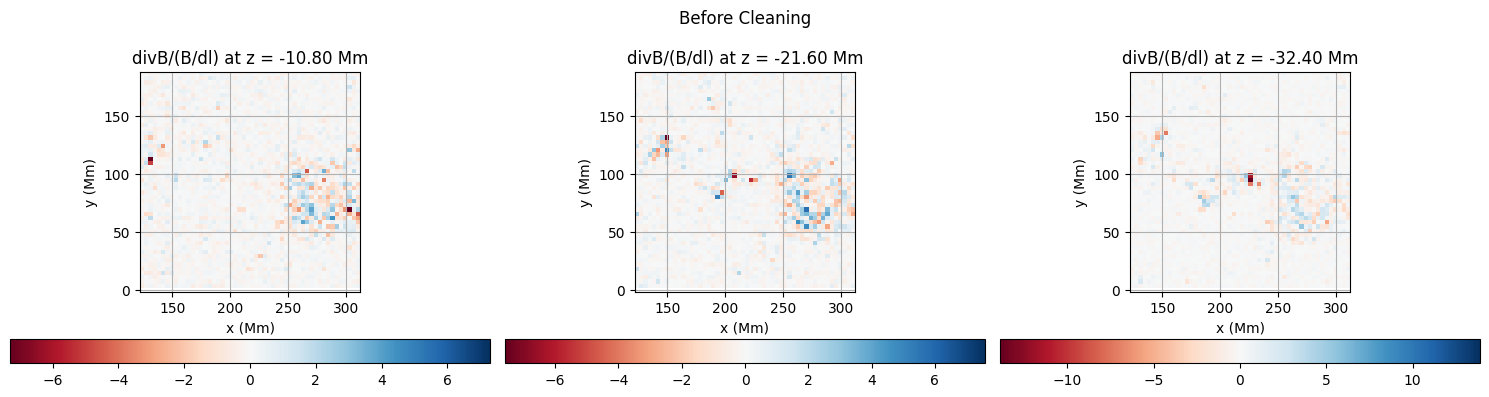

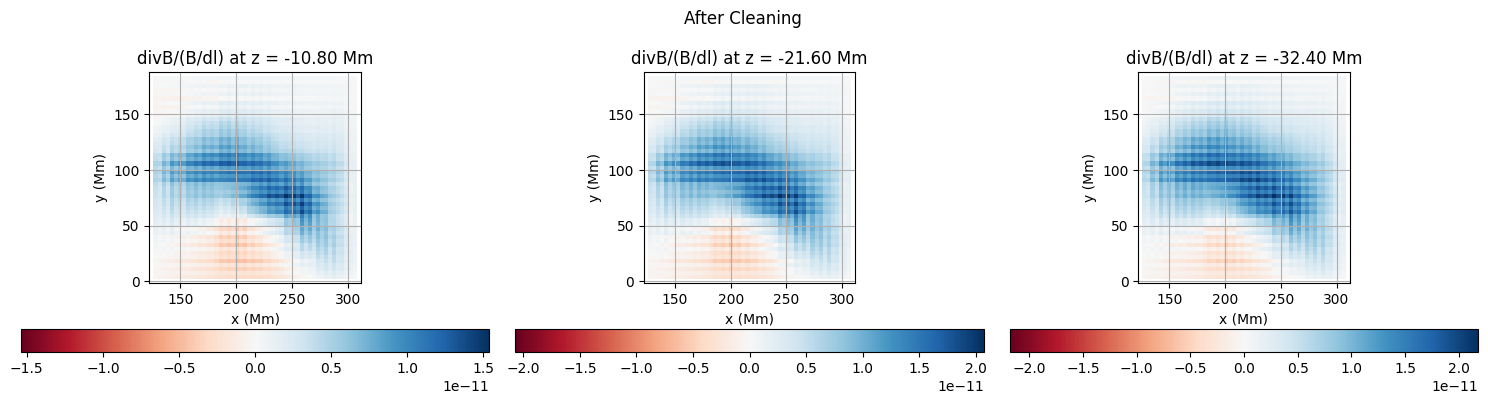

In [50]:
# Plotting x-y slices of normalized divergence
z_indices = [5,10,15]

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for i, z_idx in enumerate(z_indices):
    div_B_norm_slice = div_B_norm[nx_beg:nx_end, :, z_idx]
    max_abs_div_B_norm = np.nanmax(np.abs(div_B_norm_slice))
    c = axs[i].pcolormesh(xx_cut[:, :, z_idx] / 1e3, yy_cut[:, :, z_idx] / 1e3, div_B_norm_slice, \
                          cmap='RdBu', vmin=-max_abs_div_B_norm, vmax=max_abs_div_B_norm)
    axs[i].set_title(f'divB/(B/dl) at z = {zz[0, 0, z_idx]/1e3:.2f} Mm')
    axs[i].set_xlabel('x (Mm)')
    axs[i].set_ylabel('y (Mm)')
    axs[i].set_aspect('equal', adjustable='box')
    axs[i].grid()
    plt.colorbar(c, ax=axs[i], orientation='horizontal')

plt.suptitle('Before Cleaning')
plt.tight_layout()

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for i, z_idx in enumerate(z_indices):
    div_B_norm_slice = div_B_res_norm[:, :, z_idx]
    max_abs_div_B_norm = np.nanmax(np.abs(div_B_norm_slice))
    c = axs[i].pcolormesh(xx_cut[:, :, z_idx] / 1e3, yy_cut[:, :, z_idx] / 1e3, div_B_norm_slice, \
                          cmap='RdBu', vmin=-max_abs_div_B_norm, vmax=max_abs_div_B_norm)
    axs[i].set_title(f'divB/(B/dl) at z = {zz[0, 0, z_idx]/1e3:.2f} Mm')
    axs[i].set_xlabel('x (Mm)')
    axs[i].set_ylabel('y (Mm)')
    axs[i].set_aspect('equal', adjustable='box')
    axs[i].grid()
    plt.colorbar(c, ax=axs[i], orientation='horizontal')

plt.suptitle('After Cleaning')
plt.tight_layout()
plt.show()

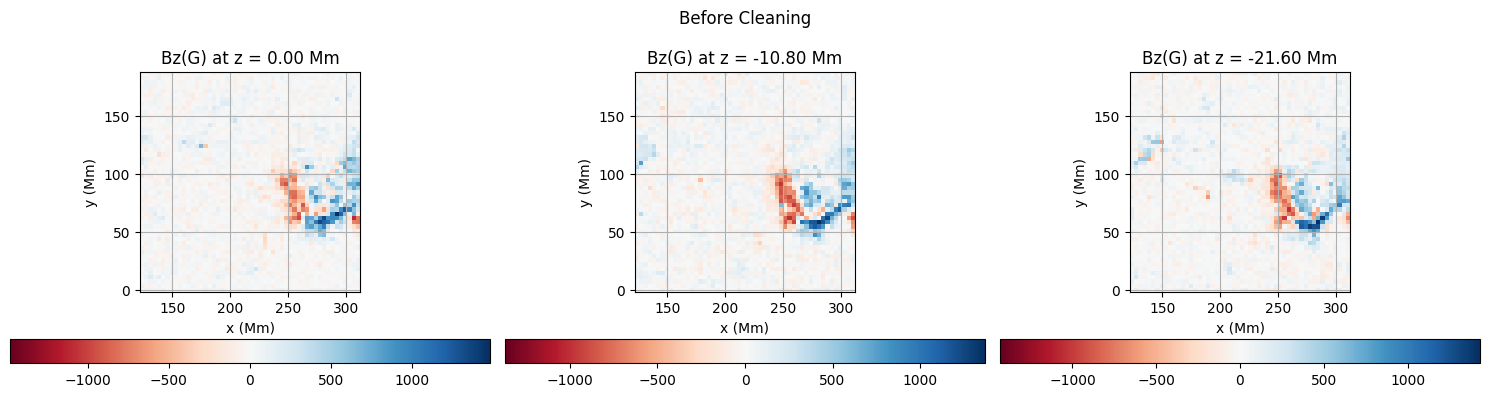

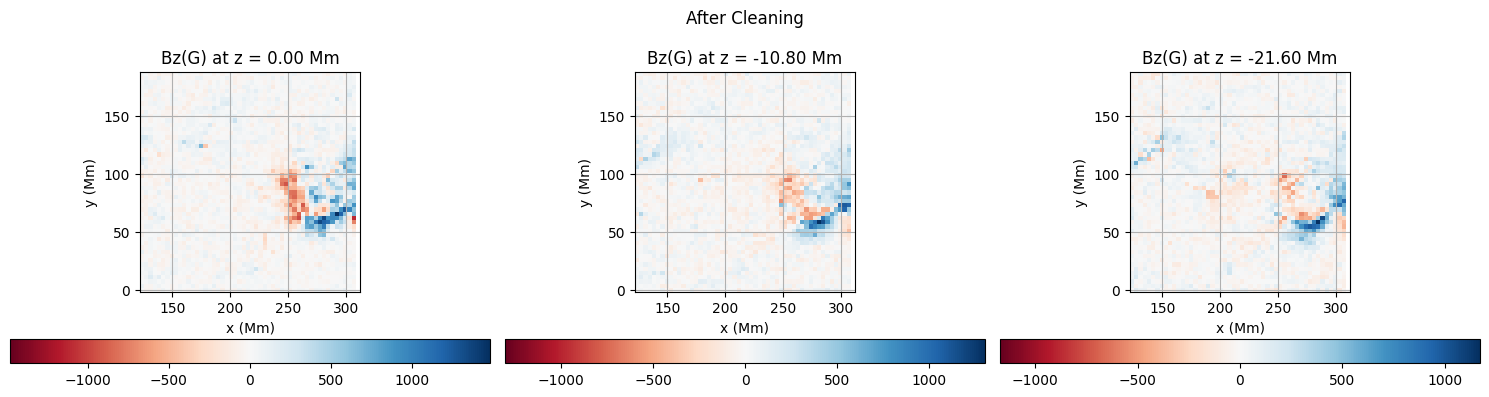

In [51]:
# Plotting x-y slices
z_indices = [0,5,10]

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for i, z_idx in enumerate(z_indices):
    Bz_slice = Bx_cut[:, :, z_idx]
    max_abs_Bz = np.nanmax(np.abs(Bz_slice))
    c = axs[i].pcolormesh(xx_cut[:, :, z_idx] / 1e3, yy_cut[:, :, z_idx] / 1e3, Bz_slice, cmap='RdBu', vmin=-max_abs_Bz, vmax=max_abs_Bz)
    axs[i].set_title(f'Bz(G) at z = {zz[0, 0, z_idx]/1e3:.2f} Mm')
    axs[i].set_xlabel('x (Mm)')
    axs[i].set_ylabel('y (Mm)')
    axs[i].set_aspect('equal', adjustable='box')
    axs[i].grid()
    plt.colorbar(c, ax=axs[i], orientation='horizontal')

plt.suptitle('Before Cleaning')
plt.tight_layout()

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for i, z_idx in enumerate(z_indices):
    Bz_slice = Bx[:, :, z_idx]
    max_abs_Bz = np.nanmax(np.abs(Bz_slice))
    c = axs[i].pcolormesh(xx_cut[:, :, z_idx] / 1e3, yy_cut[:, :, z_idx] / 1e3, Bz_slice, cmap='RdBu', vmin=-max_abs_Bz, vmax=max_abs_Bz)
    axs[i].set_title(f'Bz(G) at z = {zz[0, 0, z_idx]/1e3:.2f} Mm')
    axs[i].set_xlabel('x (Mm)')
    axs[i].set_ylabel('y (Mm)')
    axs[i].set_aspect('equal', adjustable='box')
    axs[i].grid()
    plt.colorbar(c, ax=axs[i], orientation='horizontal')

plt.suptitle('After Cleaning')
plt.tight_layout()
plt.show()

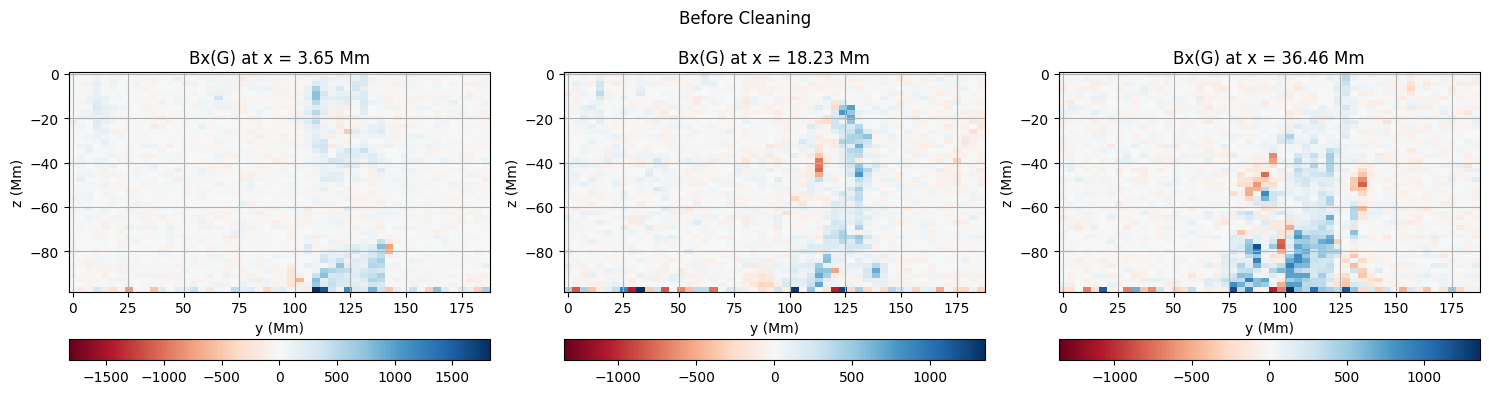

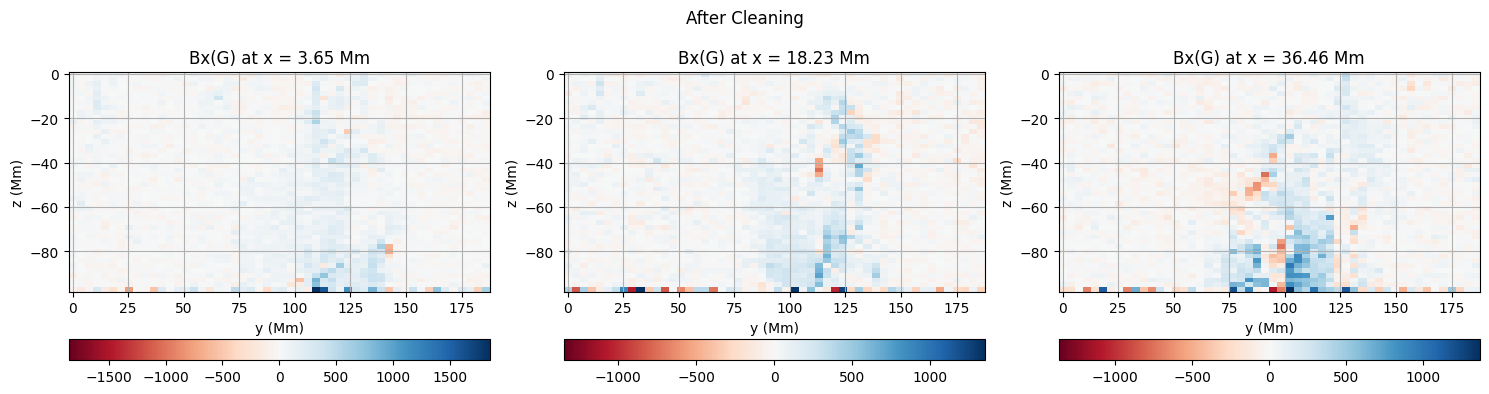

In [52]:
# Plotting y-z slices
x_indices = [1,5,10]

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for i, x_idx in enumerate(x_indices):
    Bx_slice = Bx_cut[x_idx, :, :]
    max_abs_Bx = np.nanmax(np.abs(Bx_slice))
    c = axs[i].pcolormesh(yy_cut[x_idx, :, :] / 1e3, zz_cut[x_idx, :, :] / 1e3, Bx_slice, cmap='RdBu', vmin=-max_abs_Bx, vmax=max_abs_Bx)
    axs[i].set_title(f'Bx(G) at x = {xx[x_idx, 0, 0] / 1e3:.2f} Mm')
    axs[i].set_xlabel('y (Mm)')
    axs[i].set_ylabel('z (Mm)')
    axs[i].grid()
    plt.colorbar(c, ax=axs[i], orientation='horizontal')

plt.suptitle('Before Cleaning')
plt.tight_layout()

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for i, x_idx in enumerate(x_indices):
    Bx_slice = Bx[x_idx, :, :]
    max_abs_Bx = np.nanmax(np.abs(Bx_slice))
    c = axs[i].pcolormesh(yy_cut[x_idx, :, :] / 1e3, zz_cut[x_idx, :, :] / 1e3, Bx_slice, cmap='RdBu', vmin=-max_abs_Bx, vmax=max_abs_Bx)
    axs[i].set_title(f'Bx(G) at x = {xx[x_idx, 0, 0] / 1e3:.2f} Mm')
    axs[i].set_xlabel('y (Mm)')
    axs[i].set_ylabel('z (Mm)')
    axs[i].grid()
    plt.colorbar(c, ax=axs[i], orientation='horizontal')

plt.suptitle('After Cleaning')
plt.tight_layout()
plt.show()

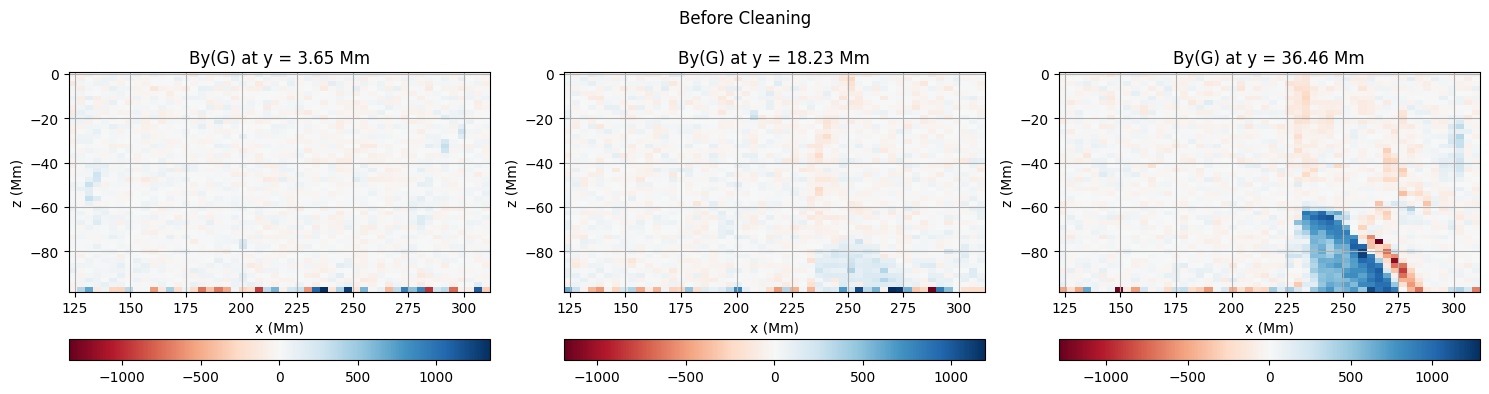

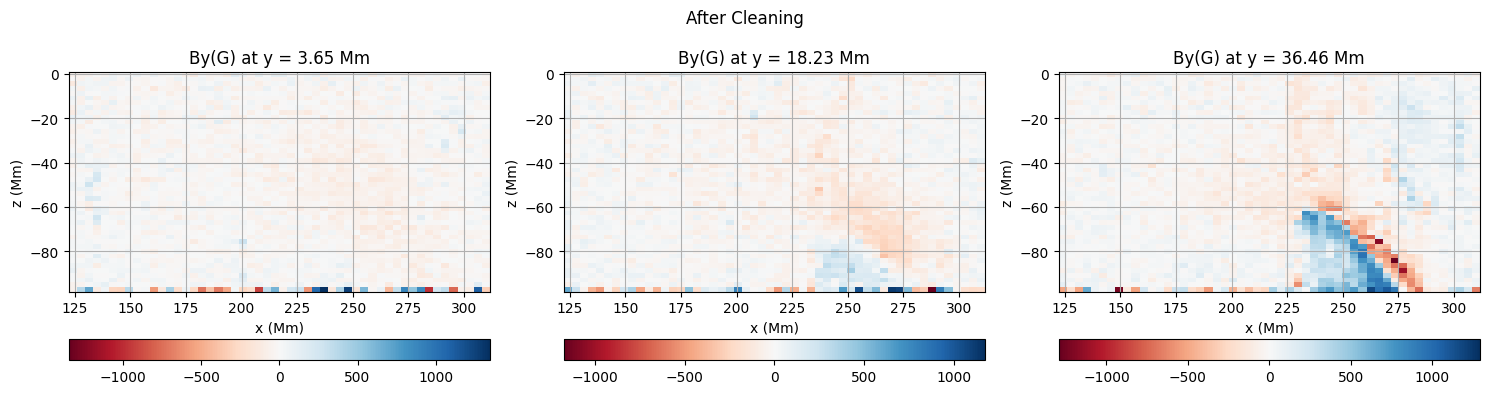

In [53]:
# Plotting x-z slices
y_indices = [1,5,10]

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for i, y_idx in enumerate(y_indices):
    By_slice = By_cut[:, y_idx, :]
    max_abs_By = np.nanmax(np.abs(By_slice))
    c = axs[i].pcolormesh(xx_cut[:, y_idx, :] / 1e3, zz_cut[:, y_idx, :] / 1e3, By_slice, cmap='RdBu', vmin=-max_abs_By, vmax=max_abs_By)
    axs[i].set_title(f'By(G) at y = {yy[0, y_idx, 0] / 1e3:.2f} Mm')
    axs[i].set_xlabel('x (Mm)')
    axs[i].set_ylabel('z (Mm)')
    axs[i].grid()
    plt.colorbar(c, ax=axs[i], orientation='horizontal')

plt.suptitle('Before Cleaning')
plt.tight_layout()

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for i, y_idx in enumerate(y_indices):
    By_slice = By[:, y_idx, :]
    max_abs_By = np.nanmax(np.abs(By_slice))
    c = axs[i].pcolormesh(xx_cut[:, y_idx, :] / 1e3, zz_cut[:, y_idx, :] / 1e3, By_slice, cmap='RdBu', vmin=-max_abs_By, vmax=max_abs_By)
    axs[i].set_title(f'By(G) at y = {yy[0, y_idx, 0] / 1e3:.2f} Mm')
    axs[i].set_xlabel('x (Mm)')
    axs[i].set_ylabel('z (Mm)')
    axs[i].grid()
    plt.colorbar(c, ax=axs[i], orientation='horizontal')

plt.suptitle('After Cleaning')
plt.tight_layout()
plt.show()